# Decompose QSO image from HST observation

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy) (pip install lenstronomy)
    - note: if python2 used, lenstronomy version 1.3.0 version is recommended (pip install lenstronomy==1.3.0 --user)
- regions (pip install regions)
- photutils (pip install photutils)

This fitting approach has been first introduced in Ding et al. 2020 ApJ 888 37 https://ui.adsabs.harvard.edu/abs/2020ApJ...888...37D/abstract

This notebook has been tested with decompsofile ==  0.1.0

For more information, please contact me: dingxuheng@126.com


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
#this drizzled image is based on HST Programme GO-15115 (PI: John Silverman),
#More details see Ding et al. 2020 ApJ 888 37 

fitsFile = pyfits.open('../example_files/HST/QSO/1147_final_drz.fits')  

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

In [3]:
import decomprofile.tools.astro_tools as astro_tools

#Load the WHT map, which would be use to derive the exposure map
wht = fitsFile[2].data

exp =  astro_tools.read_fits_exp(fitsFile[0].header)  #Read the exposure time 
mean_wht = exp * (0.0642/0.135)**2  #The drizzle information is used to derive the mean WHT value.
exp_map = exp * wht/mean_wht  #Derive the exposure time map for each pixel

## use ``decomprofile`` to process the data
- keywords in DataProcess():
    - target_pos: location of the object, default in Pixel, if [RA, Dec] is given, pos_type = 'wcs'
    - rm_bkglight: If True -- automaticlly estiamte the background light and remove.
    - zp: zeropoint value. use 27.0 for convinence.
    
- keywords in data_process.generate_target_materials()
    - radius: the radius of the cutout stamp of the QSO image, framze size = 2 * radius + 1
    - create_mask: If true, will create mask for the neighbouring objects.
    - nsigma: The s/n defined to detect all the objects in the image stamp
    - npixels: The number of connected pixels, each greater than ``threshold``,
        that an object must have to be detected.  ``npixels`` must be a
        positive integer.
    - (nsigma and npixels are introduced from photutils, method introduced in:
    https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending )
    - exp_sz: The expend level for the detected object region.
    
    

Plot target cut out zoom in:


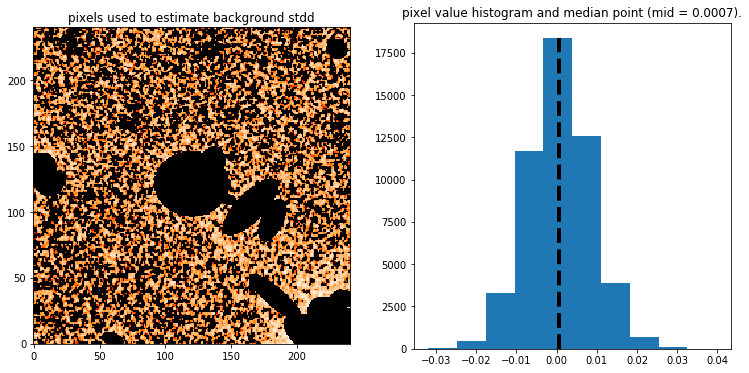

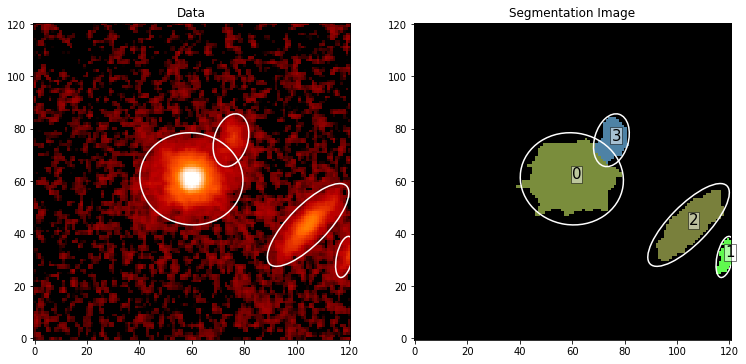

 id xcentroid ycentroid source_sum    orientation      area
       pix       pix                      deg          pix2
--- --------- --------- ---------- ------------------ -----
  2    118.37     31.13  2.7093058  77.69627934394485  54.0
  1    104.42     43.34   29.39989   45.5730063760412 338.0
  0     59.87     60.94  217.45532 -8.561561264859542 755.0
  3     74.97     75.67  7.1451707  73.71421124353299 145.0
Input directly the a obj idx to mask, use space between each id:
1


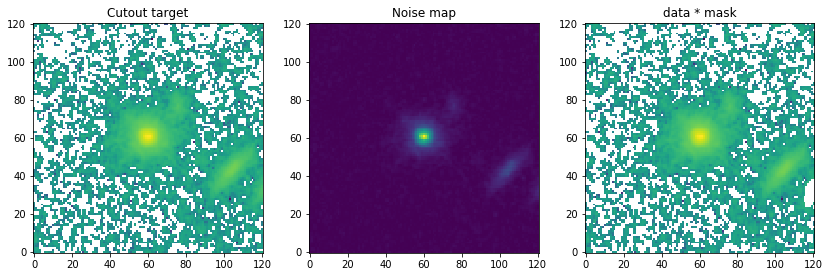

In [4]:
from decomprofile.data_process import DataProcess

#keywords see the notes above.
data_process = DataProcess(fov_image = fov_image, target_pos = [1142., 637.], pos_type = 'pixel', header = header,
                          rm_bkglight = False, exptime = exp_map, if_plot=False, zp = 27.0)  #zp use 27.0 for convinence.

data_process.generate_target_materials(radius=60, create_mask = True, nsigma=2.8,
                                      exp_sz= 1.2, npixels = 15, if_plot=True)

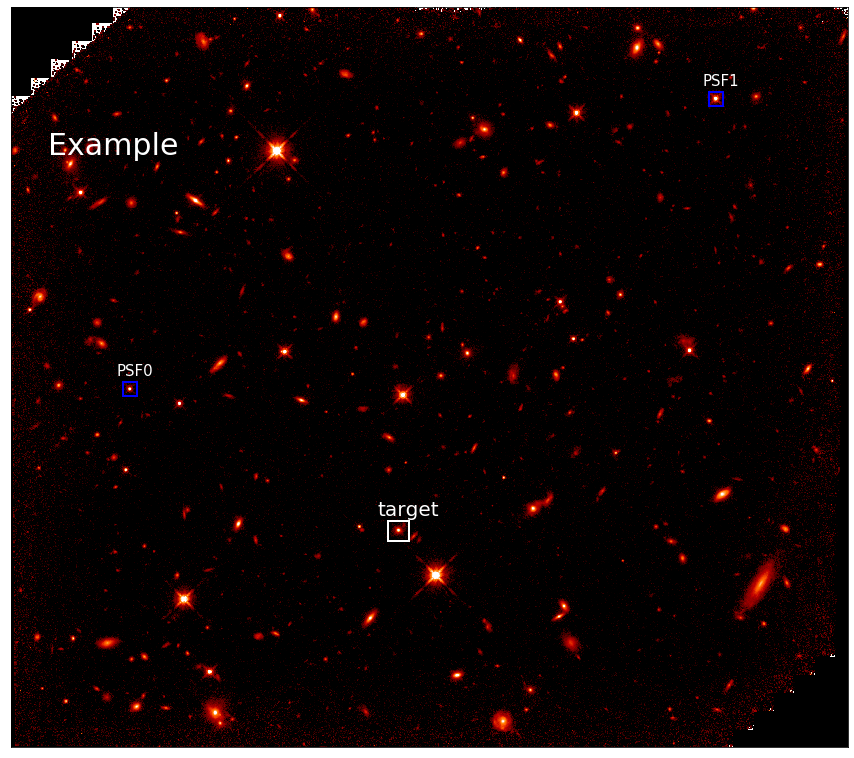

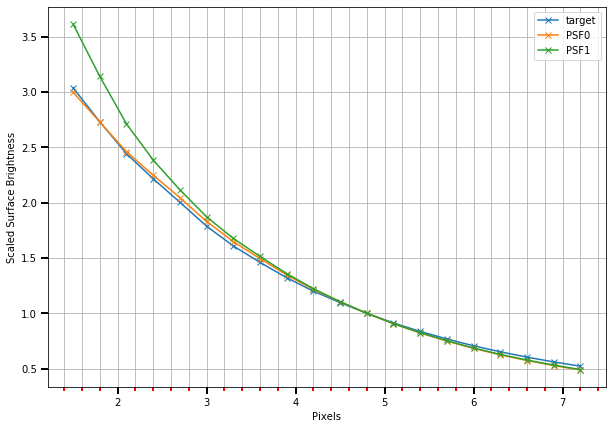

The data_process is ready to go to pass to FittingSpecify!


In [5]:
#find_PSF(): find all the available PSF in the field
#     radius: The radius to cutout the PSF
#     PSF_pos_list: input if PSF positions have selected, input. (combining with pos_type = 'pixel' (default) or 'wcs')
#     if input user_option = False: the one with smallest FWHM would be selected,
#     if input user_option = True: the user can make selection    
data_process.find_PSF(radius = 30, PSF_pos_list = [[ 350., 1055.], [2078., 1910.]])
# data_process.find_PSF(radius = 30, user_option = False) #Try this line out! 
# data_process.find_PSF(radius = 30, user_option = True)  #Try this line out! 

#Plot the FOV image and label the position of the target and the PSF
data_process.plot_overview(label = 'Example', target_label = None)

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )

#Select which PSF id you want to use to make the fitting.
data_process.psf_id_for_fitting = 1

#Check if all the materials is given, if so to pass to the next step.
data_process.checkout()

## The following box would quickly prepare the models, parameters and fitting details.

### prepare_fitting_seq includes the following keywords:
    
- point_source_num: number of point source want to used to make the fiting. 
    - point_source_num = 0: galaxy 1: QSO 2: dual AGN
- fix_n_list
    - if one wants to fix any Sersic index value for the component, [[0,4]] means fix Sersic_n of source_id = 0 to 4.
- fix_center_list:
    - if one wants to fix the QSO center to the galaxy center, [0, 1] means fix galaxy_id = 0 center to the QSO_id = 1.
- extend_source_model: manually input the models for the Sersics, i.e., ['SERSIC_ELLIPSE'] * n, n = number of Sersics.
- source_params, ps_params: manually input the galaxy paramters and PS parameters.
    
    

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


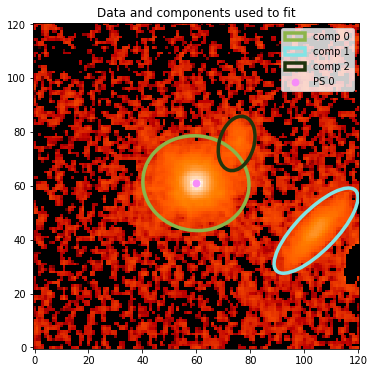

In [6]:
#Produce the class and params to make the QSO decomposition.
from decomprofile.fitting_specify import FittingSpeficy

#Pass the data_process to FittingSpeficy
fit_sepc = FittingSpeficy(data_process)

#Prepare the fitting sequence, keywords see notes above.
fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]], 
                            extend_source_model=None, source_params = None, ps_params = None)

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

#Build up and to pass to the next step.
fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Max iteration reached! Stopping.
-1.878329576021813 reduced X^2 of best position
-13667.665159922723 logL
14553.0 effective number of data points
[] lens result
[{'amp': 1, 'R_sersic': 0.1361609543390618, 'n_sersic': 4, 'e1': 0.07189197150229316, 'e2': 0.036587765074994255, 'center_x': 0.007901943401180406, 'center_y': 0.056257820829155626}, {'amp': 1, 'R_sersic': 0.5857168002078894, 'n_sersic': 1.3457326313925748, 'e1': -0.045735043036878434, 'e2': -0.4997060192760933, 'center_x': -2.8471797239116876, 'center_y': -1.0491839224180834}, {'amp': 1, 'R_sersic': 0.5075291228772332, 'n_sersic': 2.530508824555454, 'e1': -0.31343352136629427, 'e2': -0.003983809572185672, 'center_x': -1.0085324920293635, 'center_y': 1.086448698910342}] source result
[] lens light result
[{'ra_image': array([0.00790194]), 'dec_image': array([0.05625782]), 'point_amp': [1]}] point source result
{} special param result
193.5717248916626 time

100%|██████████| 130/130 [03:57<00:00,  1.82s/it]


Computing the MCMC...
Number of walkers =  170
Burn-in iterations:  100
Sampling iterations (in current run): 130
238.5740511417389 time taken for MCMC sampling
432.183 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
5100 MCMC samplers in total, finished translate: 1000
5100 MCMC samplers in total, finished translate: 2000
5100 MCMC samplers in total, finished translate: 3000
5100 MCMC samplers in total, finished translate: 4000
5100 MCMC samplers in total, finished translate: 5000


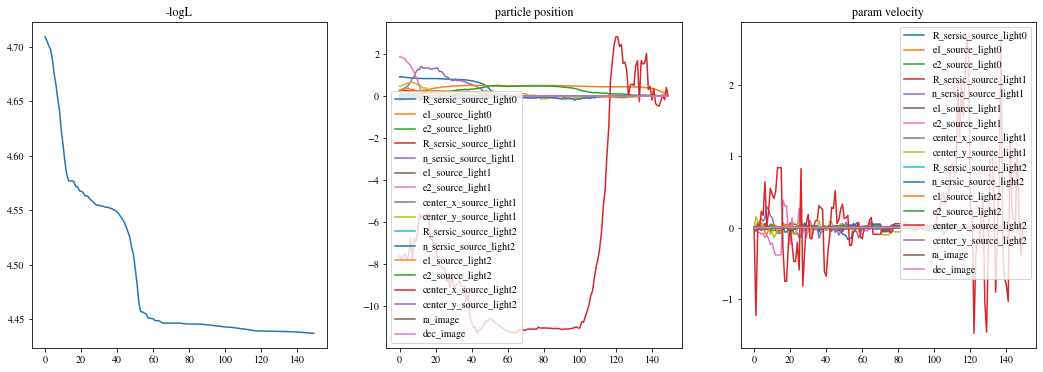

<Figure size 432x288 with 0 Axes>

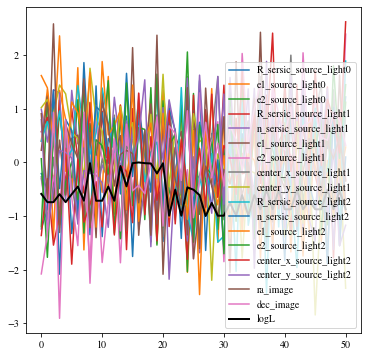

-1.8755520689866239 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.8755520689866239


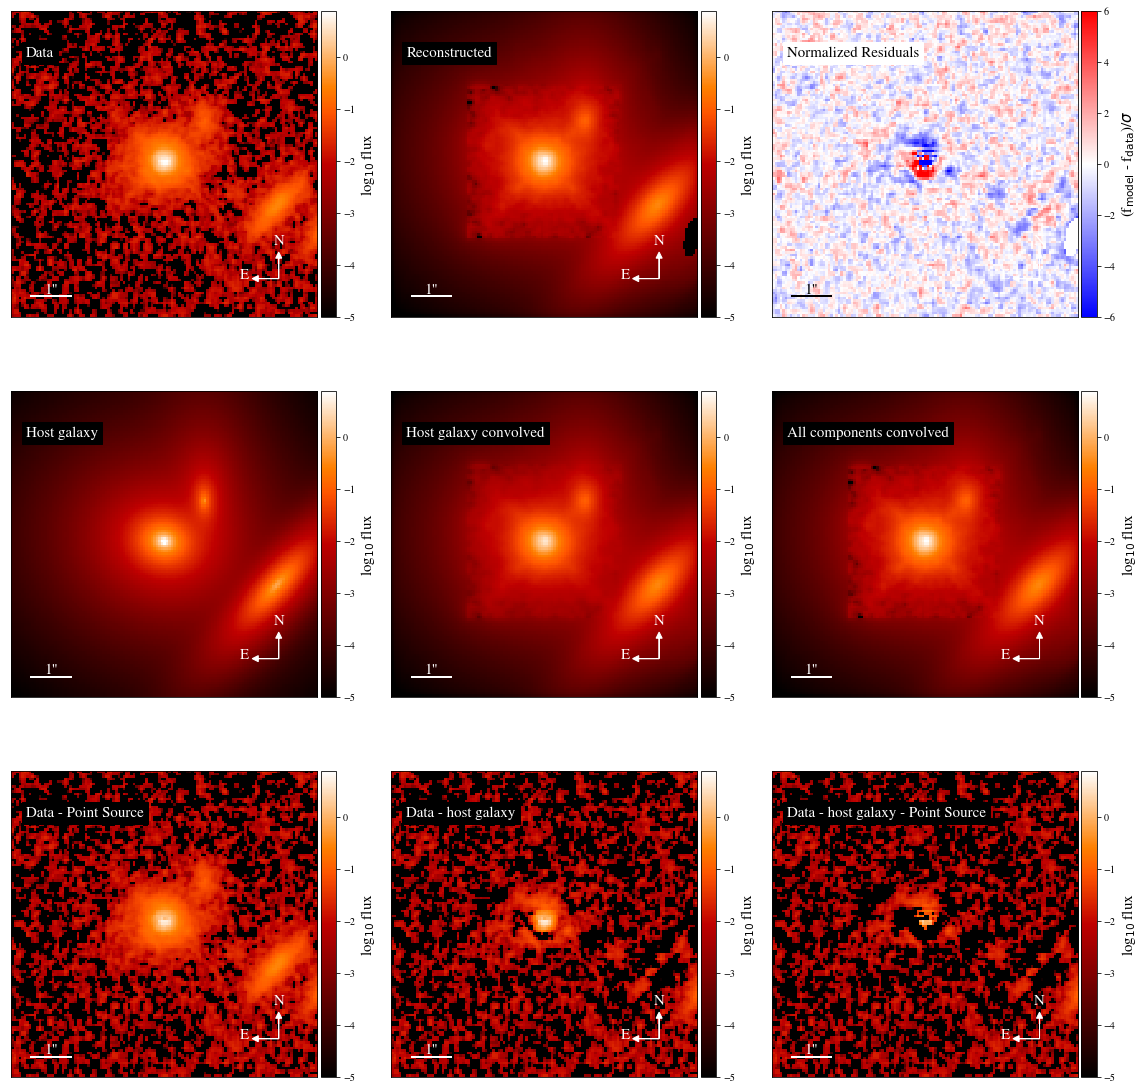

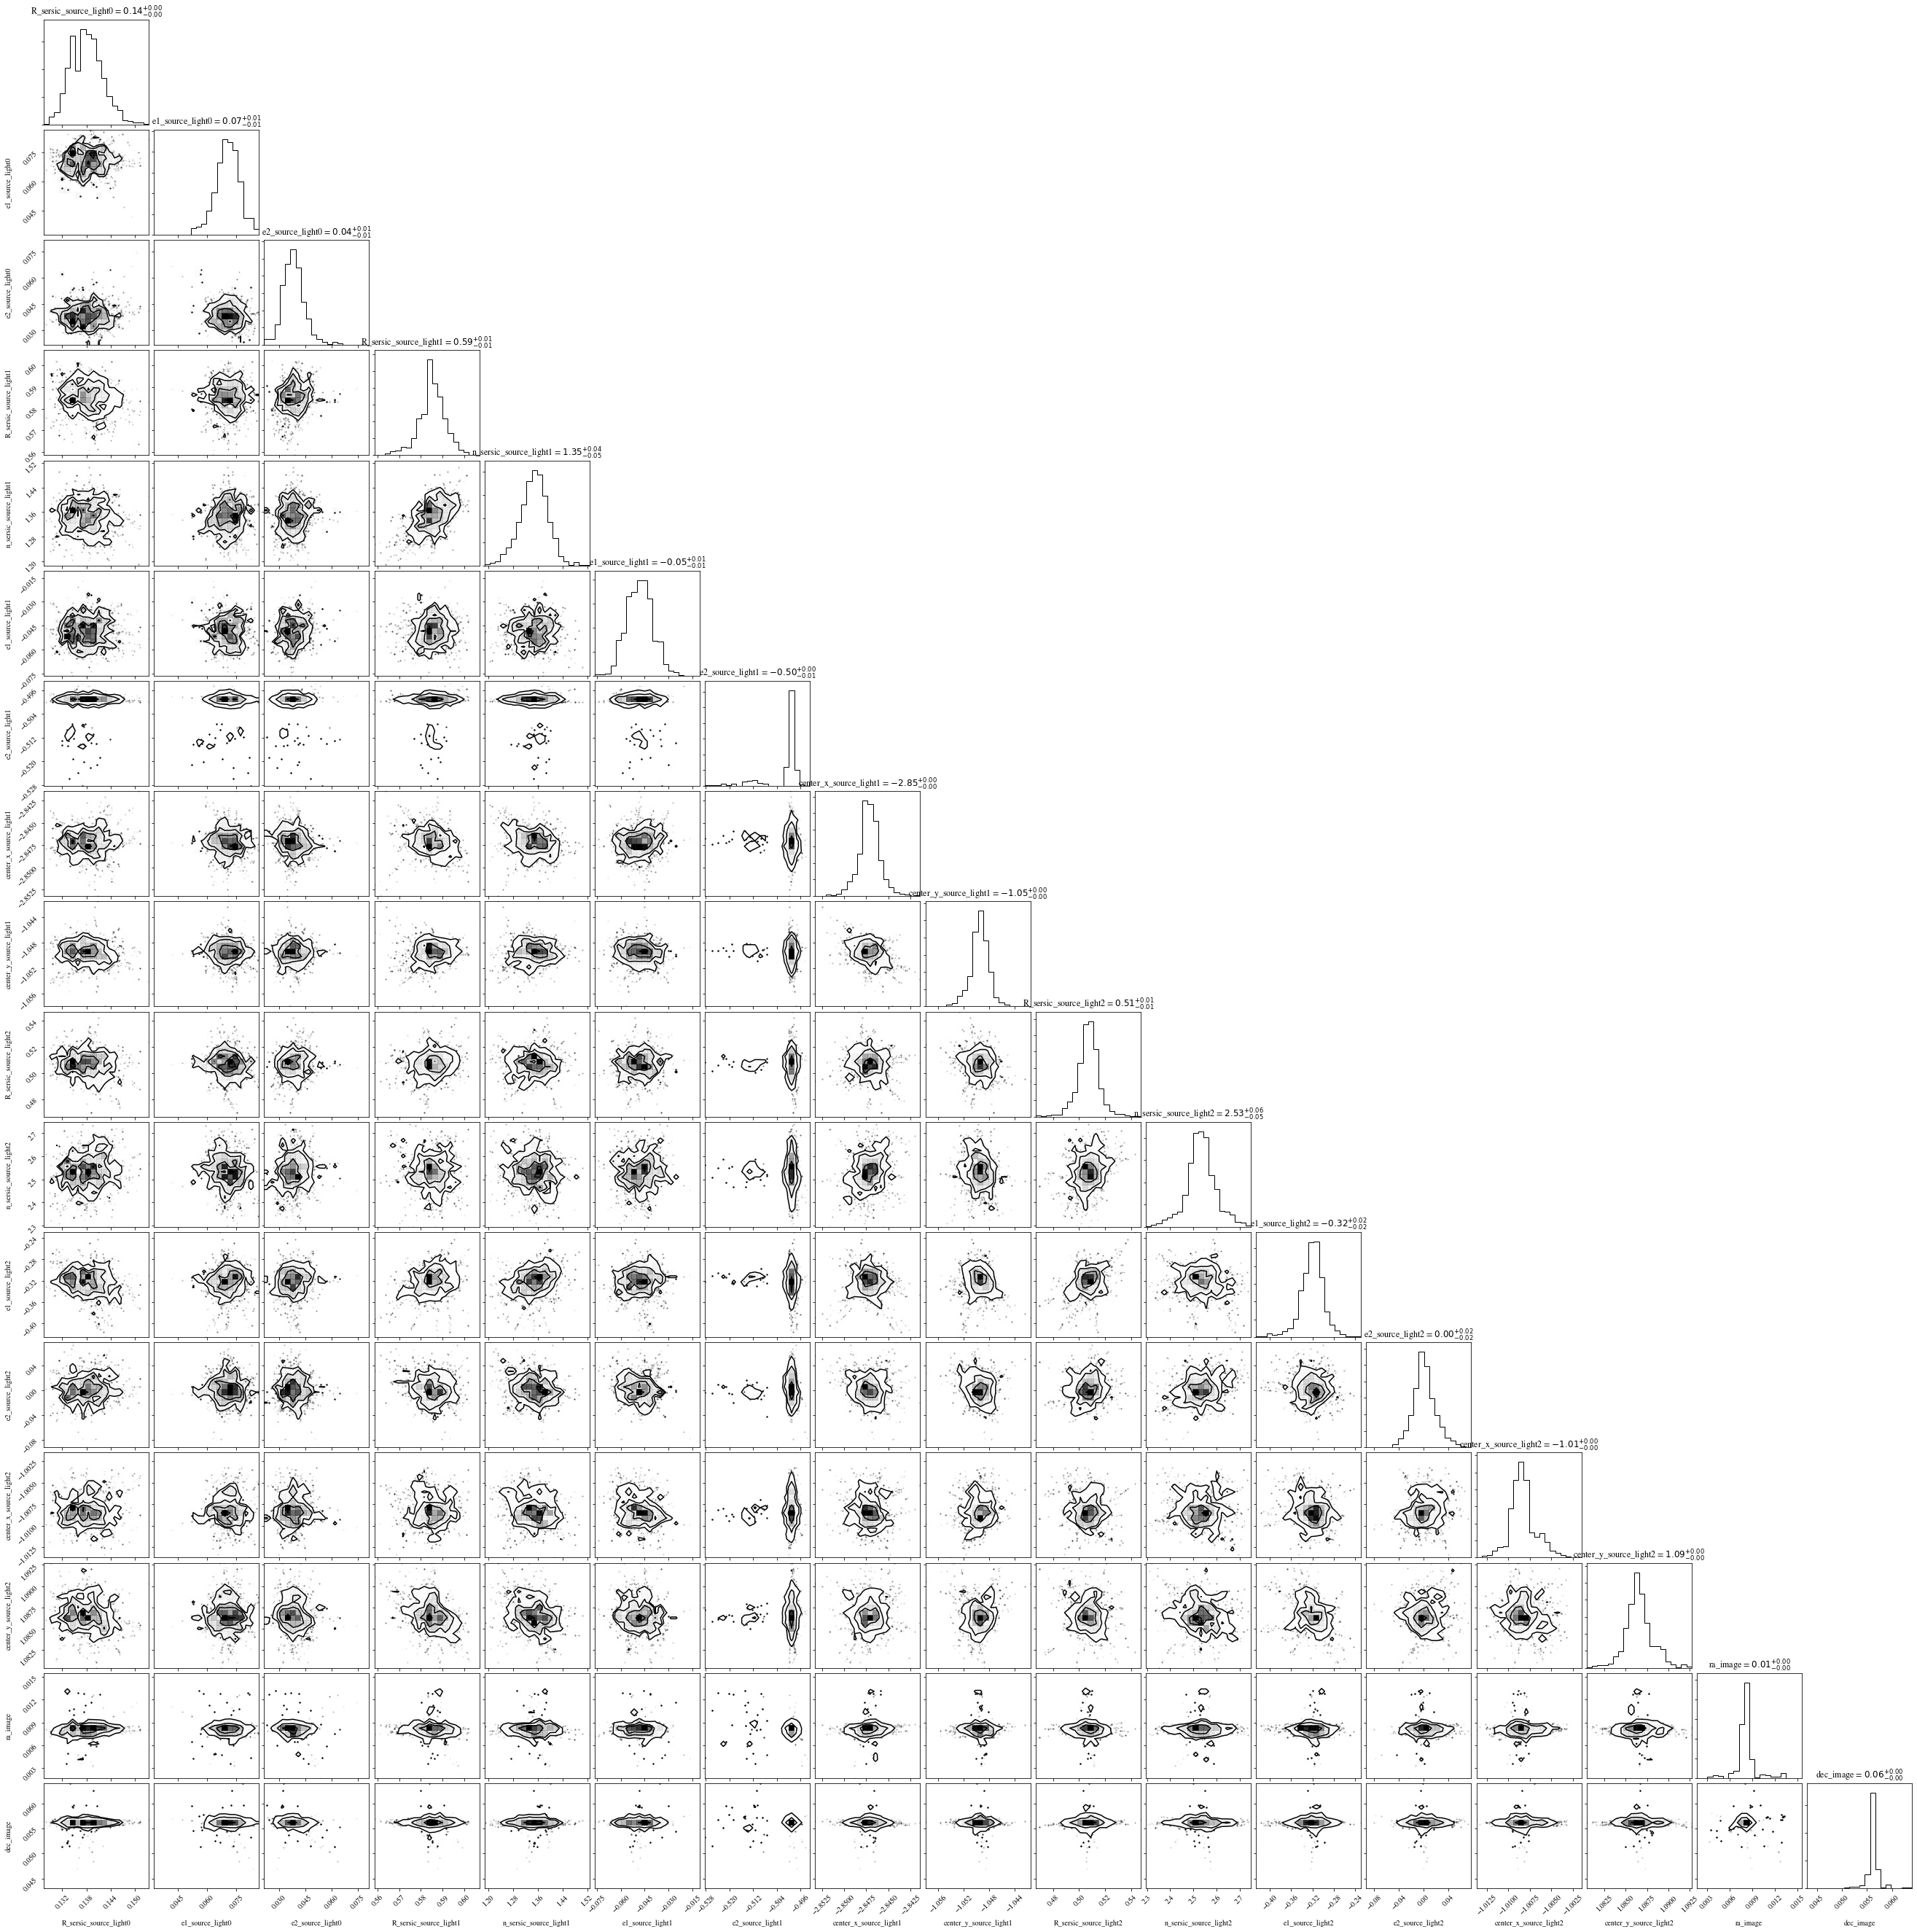

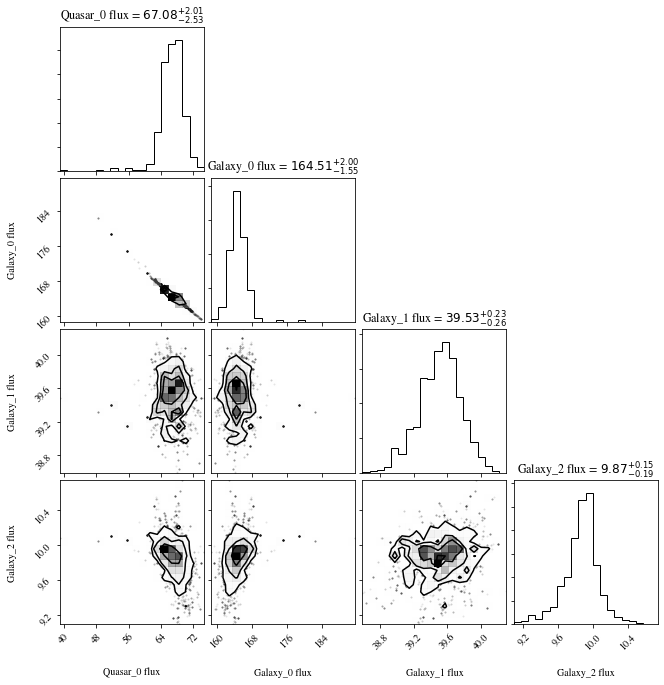

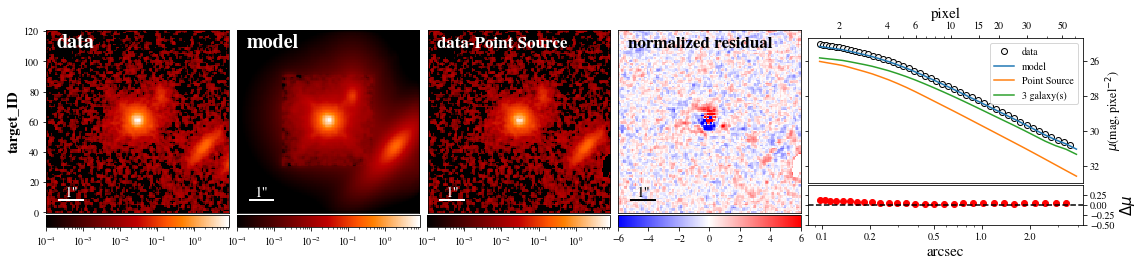

In [7]:
#Setting the fitting method and run.
from decomprofile.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HST_result')

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting: e.g. [[0.8, 50, 50], [0.8, 50, 50], [50, 100, 10, 0.1]]
#     -for PSO:
#         [0.8, 50, 50] would input: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         [50, 100, 10, 0.1] would input: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None])

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()

#Calculate the magnitude for each component, and translate e1, e1 to q, theta.
fit_run.translate_result()

#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result()

In [8]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HST_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 455.4414008279884,
  'R_sersic': 0.13806065509127913,
  'n_sersic': 4,
  'e1': 0.06921633523362235,
  'e2': 0.03679660218848521,
  'center_x': 0.008192990344115964,
  'center_y': 0.056238963722702,
  'phi_G': 0.2443101864193448,
  'q': 0.8546177134523475,
  'flux_sersic_model': 168.14967228355536,
  'flux_within_frame': 164.46329997361647,
  'magnitude': 21.459827499561086},
 {'amp': 26.18581513098847,
  'R_sersic': 0.5915380951523765,
  'n_sersic': 1.3748701890382056,
  'e1': -0.05815119052797409,
  'e2': -0.49964967743983724,
  'center_x': -2.8468017376064663,
  'center_y': -1.0496619240558898,
  'phi_G': -0.8433294997870436,
  'q': 0.3306523108680045,
  'flux_sersic_model': 41.652834551936905,
  'flux_within_frame': 39.7946638011267,
  'magnitude': 23.00043790003547},
 {'amp': 4.321898035173427,
  'R_sersic': 0.504607218799261,
  'n_sersic': 2.5104834555628983,
  'e1': -0.33676647845771757,
  'e2': 0.003265601883336489,
  'center_x': -1.0059020626536526,
  'center_y': 1.085